# Part 1: Analyzing Best-Seller Trends Across Product Categories
Objective: Understand the relationship between product categories and their best-seller status.

Crosstab Analysis:

Create a crosstab between the product category and the isBestSeller status.

Are there categories where being a best-seller is more prevalent?

Hint: one option is to calculate the proportion of best-sellers for each category and then sort the categories based on this proportion in descending order.

Statistical Tests:

Conduct a Chi-square test to determine if the best-seller distribution is independent of the product category.
Compute Cramér's V to understand the strength of association between best-seller status and category.
Visualizations:

Visualize the relationship between product categories and the best-seller status using a stacked bar chart.


In [64]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr

In [40]:
data = pd.read_csv("amz_uk_price_prediction_dataset.csv")

In [41]:
data.columns

Index(['uid', 'asin', 'title', 'stars', 'reviews', 'price', 'isBestSeller',
       'boughtInLastMonth', 'category'],
      dtype='object')

In [42]:
top_categories = data['category'].value_counts()

In [43]:
top_categories

category
Sports & Outdoors                         836265
Beauty                                     19312
Handmade Clothing, Shoes & Accessories     19229
Bath & Body                                19092
Birthday Gifts                             18978
                                           ...  
Alexa Built-In Devices                       107
Motorbike Chassis                            107
Plugs                                        107
Smart Home Security & Lighting               104
Smart Speakers                                54
Name: count, Length: 296, dtype: int64

In [44]:
top_10_list = [top_categories.index[i] for i in range(10)]
top_10_list

['Sports & Outdoors',
 'Beauty',
 'Handmade Clothing, Shoes & Accessories',
 'Bath & Body',
 'Birthday Gifts',
 'Manicure & Pedicure Products',
 'Skin Care',
 'Make-up',
 'Hair Care',
 'Fragrances']

In [45]:
data_subset = data[data["category"].isin (top_10_list)]
data_subset = data_subset.reset_index()
data_subset.shape

(1006640, 10)

In [46]:
Q1 = data_subset['price'].quantile(0.25)
Q3 = data_subset['price'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define the lower and upper bounds for potential outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a subset of data by dropping the outliers based on the IQR range
data_wo = data_subset[(data_subset['price'] > lower_bound) & (data_subset['price'] < upper_bound) & (data_subset['reviews'] > 9)]


In [47]:
data_wo.shape

(172326, 10)

In [48]:
cross_table = pd.crosstab(data_wo['category'], data_wo['isBestSeller'])

In [49]:
# Calculating Cramer's V
chi2, p, dof, expected = chi2_contingency(cross_table)
n = cross_table.sum().sum()
phi2 = chi2 / n
r, k = cross_table.shape
cramer_v = np.sqrt(phi2 / (min(k-1, r-1))).round(4)

print("Cramer's V:", cramer_v)
chi2_contingency(cross_table)
print(f"degrees of freedom {dof} p-value = {p}")
cross_table

Cramer's V: 0.0569
degrees of freedom 9 p-value = 1.747127585497008e-114


isBestSeller,False,True
category,,
Bath & Body,13928,33
Beauty,17930,299
Birthday Gifts,2229,34
Fragrances,10002,14
Hair Care,15948,68
"Handmade Clothing, Shoes & Accessories",923,11
Make-up,13656,41
Manicure & Pedicure Products,12411,58
Skin Care,15742,58


In [50]:
cross_table_prop = cross_table.copy()

In [51]:
cross_table_prop.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, Bath & Body to Sports & Outdoors
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   False   10 non-null     int64
 1   True    10 non-null     int64
dtypes: int64(2)
memory usage: 240.0+ bytes


In [52]:
cross_table_prop["prop"]= cross_table[True]/(cross_table[True]+cross_table[False])

In [53]:
cross_table_prop.sort_values(by='prop',ascending=False)

isBestSeller,False,True,prop
category,,,
Beauty,17930,299,0.016402
Birthday Gifts,2229,34,0.015024
"Handmade Clothing, Shoes & Accessories",923,11,0.011777
Manicure & Pedicure Products,12411,58,0.004652
Sports & Outdoors,68637,304,0.004410
Hair Care,15948,68,0.004246
Skin Care,15742,58,0.003671
Make-up,13656,41,0.002993
Bath & Body,13928,33,0.002364



# Part 2: Exploring Product Prices and Ratings Across Categories and Brands
Objective: Investigate how different product categories influence product prices.

Preliminary Step: Remove outliers in product prices.

For this purpose, we can use the IQR (Interquartile Range) method. Products priced below the first quartile minus 1.5 times the IQR or above the third quartile plus 1.5 times the IQR will be considered outliers and removed from the dataset. The next steps will be done with the dataframe without outliers.

Hint: you can check the last Check For Understanding at the end of the lesson EDA Bivariate Analysis for a hint on how to do this.


In [17]:
Q1 = data_subset['price'].quantile(0.25)
Q3 = data_subset['price'].quantile(0.75)

# Calculate IQR
IQR = Q3 - Q1

# Define the lower and upper bounds for potential outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Create a subset of data by dropping the outliers based on the IQR range
data_wo = data_subset[(data_subset['price'] > lower_bound) & (data_subset['price'] < upper_bound)]



Violin Plots:

Use a violin plot to visualize the distribution of price across different product categories. Filter out the top 20 categories based on count for better visualization.
Which product category tends to have the highest median price? Don't filter here by top categories.


In [54]:
data_wo.columns

Index(['index', 'uid', 'asin', 'title', 'stars', 'reviews', 'price',
       'isBestSeller', 'boughtInLastMonth', 'category'],
      dtype='object')

C:\Users\juanf\AppData\Local\Temp\ipykernel_20560\3564297788.py:3: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  vioplot.set_xticklabels(vioplot.get_xticklabels(), rotation=90)


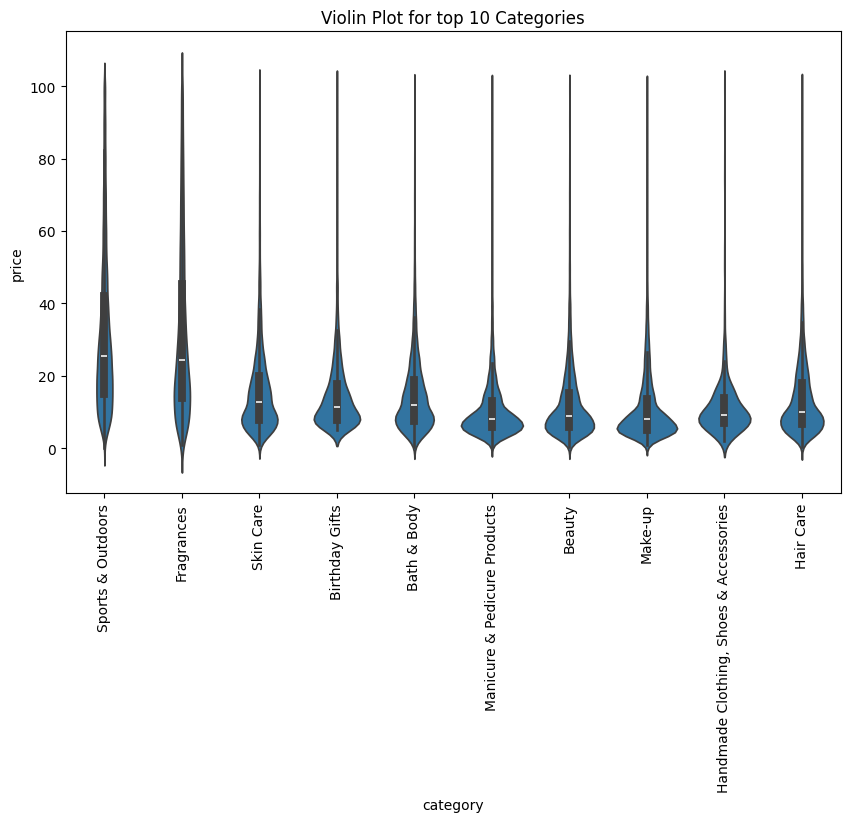

In [55]:
plt.figure(figsize=(10, 6))  # Set the figure size
vioplot=sns.violinplot(x='category', y='price', data=data_wo)
vioplot.set_xticklabels(vioplot.get_xticklabels(), rotation=90)
plt.title('Violin Plot for top 10 Categories')
plt.show()



Bar Charts:

Create a bar chart comparing the average price of products for the top 10 product categories (based on count).
Which product category commands the highest average price? Don't filter here by top categories.
Box Plots:

Visualize the distribution of product ratings based on their category using side-by-side box plots. Filter out the top 10 categories based on count for better visualization.
Which category tends to receive the highest median rating from customers? Don't filter here by top categories.


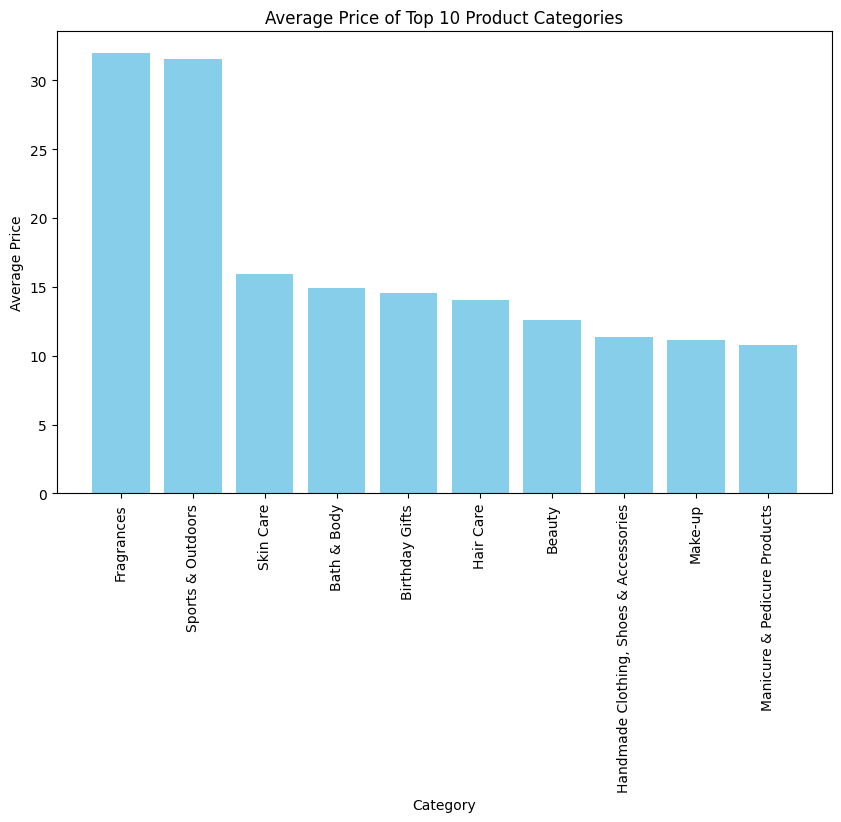

In [56]:
avg_prices = data_wo.groupby('category')['price'].mean().sort_values(ascending=False)

# Select the top 10 categories based on count
#top_10_categories = avg_prices.head(10)

# Create a bar chart to compare the average prices for the top 10 categories
plt.figure(figsize=(10, 6))
plt.bar(avg_prices.index, avg_prices.values, color='skyblue')
plt.title('Average Price of Top 10 Product Categories')
plt.xlabel('Category')
plt.ylabel('Average Price')
plt.xticks(rotation=90)
plt.show()

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
 [Text(0, 0, 'Sports & Outdoors'),
  Text(1, 0, 'Fragrances'),
  Text(2, 0, 'Skin Care'),
  Text(3, 0, 'Birthday Gifts'),
  Text(4, 0, 'Bath & Body'),
  Text(5, 0, 'Manicure & Pedicure Products'),
  Text(6, 0, 'Beauty'),
  Text(7, 0, 'Make-up'),
  Text(8, 0, 'Handmade Clothing, Shoes & Accessories'),
  Text(9, 0, 'Hair Care')])

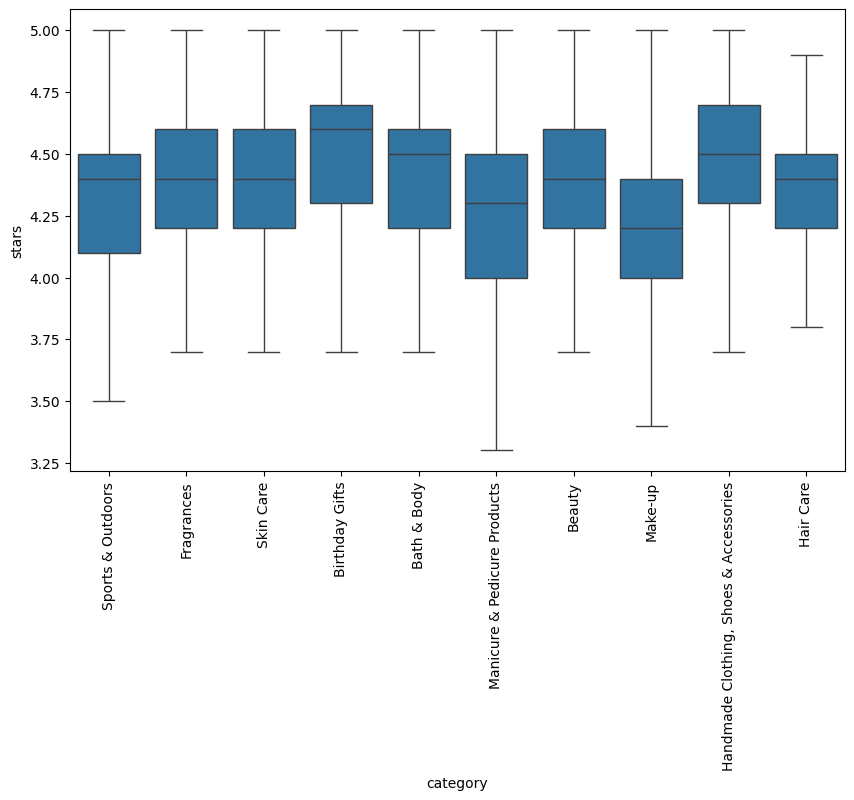

In [57]:
plt.figure(figsize=(10, 6))  # Set the size of the plot
sns.boxplot(x='category', y='stars', data=data_wo, showfliers=False)
plt.xticks(rotation=90)

In [58]:
data_wo.groupby('category')['stars'].median().sort_values(ascending=False)

category
Birthday Gifts                            4.6
Bath & Body                               4.5
Handmade Clothing, Shoes & Accessories    4.5
Beauty                                    4.4
Fragrances                                4.4
Hair Care                                 4.4
Skin Care                                 4.4
Sports & Outdoors                         4.4
Manicure & Pedicure Products              4.3
Make-up                                   4.2
Name: stars, dtype: float64


# Part 3: Investigating the Interplay Between Product Prices and Ratings
Objective: Analyze how product ratings (stars) correlate with product prices.

Correlation Coefficients:

Calculate the correlation coefficient between price and stars.
Is there a significant correlation between product price and its rating?


In [59]:
from scipy.stats import pearsonr

# Pearson's correlation test between 'LotArea' and 'SalePrice'
correlation_coef, p_value = pearsonr(data_wo['price'], data_wo['stars'])
print("Correlation Coefficient:", correlation_coef)
print("P-value:", p_value)

Correlation Coefficient: 0.11299285939591047
P-value: 0.0


In [65]:
correlation, p_value = spearmanr(data_wo['price'], data_wo['stars'])
print(f"Spearman correlation: {correlation}")
print(f"P-value: {p_value}")

Spearman correlation: 0.15342636470258877
P-value: 0.0



Visualizations:

Use a scatter plot to visualize the relationship between product rating and price. What patterns can you observe?
Use a correlation heatmap to visualize correlations between all numerical variables.
Examine if product prices typically follow a normal distribution using a QQ plot.
Submission: Submit a Jupyter Notebook which contains code and a business-centric report summarizing your findings.

Bonus:

Do the same analysis without taking out the outliers. What are your insights?

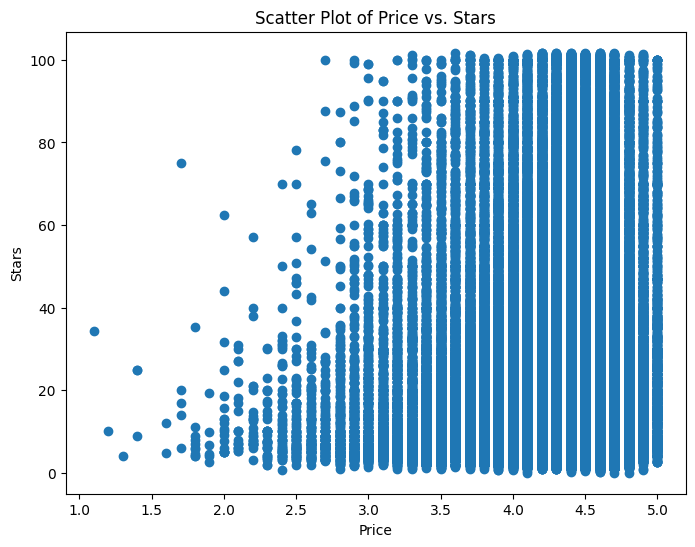

In [60]:
plt.figure(figsize=(8, 6))  # Set the size of the plot
plt.scatter(data_wo['stars'], data_wo['price'])
plt.title('Scatter Plot of Price vs. Stars')
plt.xlabel('Price')
plt.ylabel('Stars')
plt.show()

In [61]:
data_wo.nunique()

index                172326
uid                  172326
asin                 151615
title                146469
stars                    39
reviews                9269
price                  8871
isBestSeller              2
boughtInLastMonth        23
category                 10
dtype: int64

In [62]:
data_wo['reviews'].value_counts()

reviews
10       3461
11       3175
12       2840
13       2622
14       2582
         ... 
52094       1
43719       1
7770        1
8295        1
15594       1
Name: count, Length: 9269, dtype: int64

In [63]:
data_wo.head()

,index,uid,asin,title,stars,reviews,price,isBestSeller,boughtInLastMonth,category
0,82163,89483,B07DLGZ828,Neutrade GoPro 3M Sticky Pads Double Sided Adh...,4.2,3116,6.49,False,0,Sports & Outdoors
1,82164,89484,B09HGZHXJT,"WOLFANG Action Camera 4K 20MP GA100, Waterproo...",4.2,2594,49.99,False,0,Sports & Outdoors
4,82167,89487,B08LD4VXGL,FitStill 60M/196FT Waterproof Case for Go Pro ...,4.5,9879,16.98,True,0,Sports & Outdoors
5,82168,89488,B07QDMLMJH,Nextbase Powered Mount Variations For Cameras ...,4.7,1223,19.95,False,0,Sports & Outdoors
6,82169,89489,B09TQMCNY7,WOLFANG Action Camera GA100 with 64GB microSDX...,4.2,55,49.99,False,0,Sports & Outdoors
